### HEALTH INSURANCE COST DATA ANALYSIS AND APPLICATION OF MACHINE LEARNING ALGORITHMS

The growing emphasis of health equity has recently become a major priority in the United States and it has contributed to the rising healthcare costs. Leveraging health insurance data to predict future claims costs and identifying key factors that drive these  escalating costs can provide actionable insights to improve decision-making and expense management of health insurance providers.
### Problem Statements:
1. Based on an individual’s demographic and lifestyle, can we predict the individual’s health insurance charges accurately?
2. Can we classify individuals who are likely to incur high versus low health insurance costs?
3. What factors strongly influence health insurance costs?

   

In [96]:
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


In [4]:
# Read data in
raw_data = pd.read_csv('data/health_ins_data.csv')
raw_data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [5]:
# Stats Summary
raw_data.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
# Check for missing values
missing_values = raw_data.isna().mean().round(4) * 100
missing_values

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [7]:
# Check for duplicates
duplicates = raw_data[raw_data.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 1435


In [8]:
# Check details of duplicates including original
raw_data['duplicate_count'] = raw_data.groupby(list(raw_data.columns))[list(raw_data.columns)[0]].transform('count')
duplicates_all = raw_data[raw_data.duplicated(keep=False)].sort_values(by=list(raw_data.columns), kind='mergesort')

print(f"Number of duplicated records (including originals): {duplicates_all.shape[0]}")
duplicates_all

Number of duplicated records (including originals): 2772


,age,sex,bmi,children,smoker,region,charges,duplicate_count
359,18,female,20.79,0,no,southeast,1607.5101,2
1745,18,female,20.79,0,no,southeast,1607.5101,2
1282,18,female,21.66,0,yes,northeast,14283.4594,2
2668,18,female,21.66,0,yes,northeast,14283.4594,2
469,18,female,24.09,1,no,southeast,2201.0971,2
...,...,...,...,...,...,...,...,...
2021,64,male,38.19,0,no,northeast,14410.9321,2
418,64,male,39.16,1,no,southeast,14418.2804,2
1804,64,male,39.16,1,no,southeast,14418.2804,2
534,64,male,40.48,0,no,southeast,13831.1152,2


In [9]:
# Show some records with more than 2 duplicates
raw_data[raw_data['duplicate_count'] > 2].sort_values(by=list(raw_data.columns), kind='mergesort')

,age,sex,bmi,children,smoker,region,charges,duplicate_count
1248,18,female,39.82,0,no,southeast,1633.9618,4
1357,18,female,39.82,0,no,southeast,1633.9618,4
2634,18,female,39.82,0,no,southeast,1633.9618,4
2743,18,female,39.82,0,no,southeast,1633.9618,4
940,18,male,23.21,0,no,southeast,1121.8739,4
...,...,...,...,...,...,...,...,...
2747,62,female,39.16,0,no,southeast,13470.8044,4
1241,64,male,36.96,2,yes,southeast,49577.6624,4
1350,64,male,36.96,2,yes,southeast,49577.6624,4
2627,64,male,36.96,2,yes,southeast,49577.6624,4


In [10]:
# Remove duplicates, keep first occurrence
df_nodups = raw_data.drop_duplicates()

print(f"Rows before: {raw_data.shape[0]}, after: {df_nodups.shape[0]}")


Rows before: 2772, after: 1337


#### Decided to remove duplicates because they can create bias in the model learning phase and poor generalization on new and unseen data 

In [20]:
# Delete duplicate count column since it is no longer needed
df_nodups.drop(columns=['duplicate_count'], inplace=True)
df_nodups

/var/folders/bs/1wybxlr17fg3bj7w8dhxkg1r0000gn/T/ipykernel_4131/3840494970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodups.drop(columns=['duplicate_count'], inplace=True)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [36]:
Q1 = df_nodups['charges'].quantile(0.25)
Q3 = df_nodups['charges'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df_nodups[(df_nodups['charges'] < lower_bound) | (df_nodups['charges'] > upper_bound)]
num_outliers = df_nodups[(df_nodups['charges'] < lower_bound) | (df_nodups['charges'] > upper_bound)].shape[0]

print(f"First Quartile: {Q1}")
print(f"Third Quartile: {Q3}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Number of outliers in price: {num_outliers}")


First Quartile: 4746.344
Third Quartile: 16657.71745
Lower Bound: -13120.716174999998
Upper Bound: 34524.777625
Number of outliers in price: 139


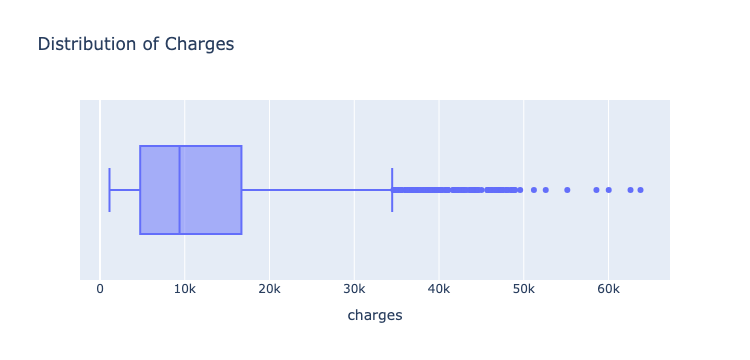

In [38]:
# Visualize outlier for charges

fig1 = px.box(df_nodups, x='charges', title='Distribution of Charges')
fig1.show()

In [40]:
# Create a new df without outliers (based on charges)
healthins_df = df_nodups[(df_nodups['charges'] >= lower_bound) & (df_nodups['charges'] <= upper_bound)]
healthins_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


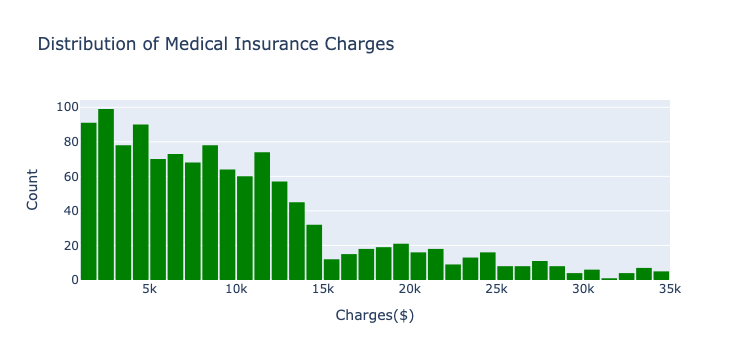

In [42]:
fig = px.histogram(
    healthins_df,
    x='charges',
    nbins=50,                      # number of bins
    title='Distribution of Medical Insurance Charges',
    labels={'charges': 'Insurance Charges'}, # label for x-axis
    color_discrete_sequence=['green']  # optional custom color
)

fig.update_layout(
    xaxis_title='Charges($)',
    yaxis_title='Count',
    bargap=0.1
)

fig.show()

In [44]:
# Look at number of rows/columns, summary statistics and data types (total counts of numberical/categorical)
print("The data has {} rows and {} columns".format(healthins_df.shape[0], healthins_df.shape[1]))
display(healthins_df.describe())
display(healthins_df.dtypes.value_counts())

The data has 1198 rows and 7 columns


,age,bmi,children,charges
count,1198.000000,1198.000000,1198.000000,1198.000000
mean,39.006678,30.094787,1.085142,9934.671758
std,14.062040,6.013044,1.214407,7240.216987
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,25.800000,0.000000,4418.591062
50%,39.000000,29.735000,1.000000,8411.754950
75%,51.000000,33.820000,2.000000,12955.356300
max,64.000000,53.130000,5.000000,34472.841000


object     3
int64      2
float64    2
dtype: int64

In [46]:
corr_matrix = healthins_df.corr()

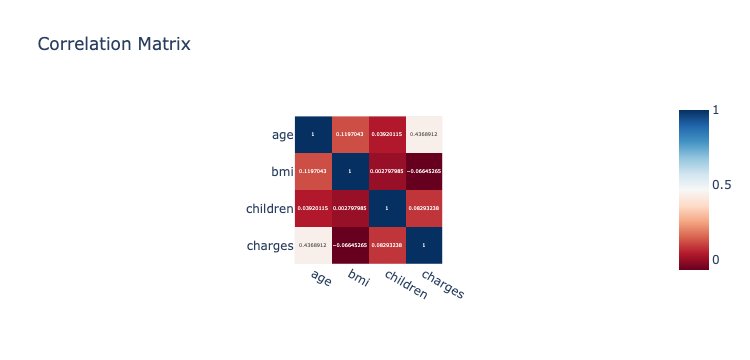

In [48]:
fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu',
    title="Correlation Matrix"
)
fig.show()

In [50]:
category_vars = healthins_df.columns[healthins_df.dtypes == 'object'].tolist()
category_vars

['sex', 'smoker', 'region']

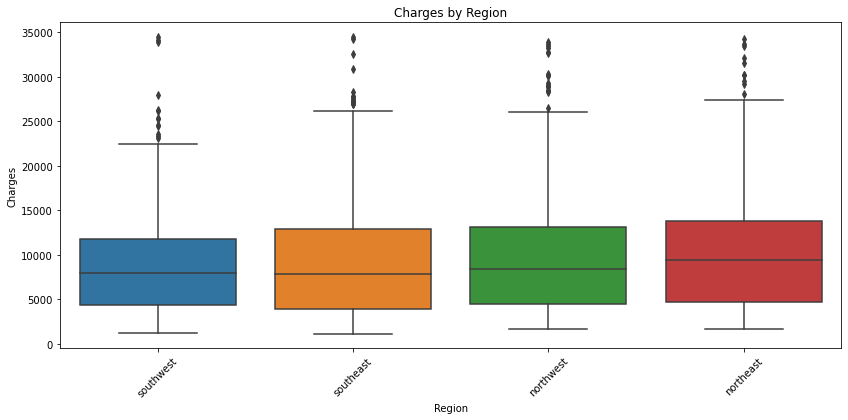

In [66]:
# Visualize Charges by Region
plt.figure(figsize=(14, 6))
sns.boxplot(data=healthins_df, x='region', y='charges')

plt.title('Charges by Region')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

plt.savefig('images/charges_byregion.png')

plt.show()

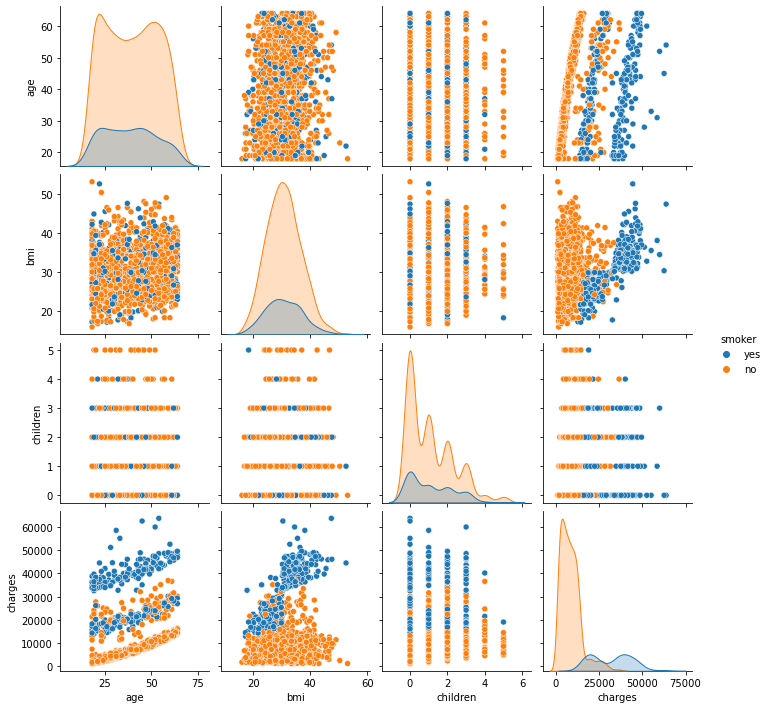

In [68]:
sns.pairplot(df_nodups, hue = 'smoker');


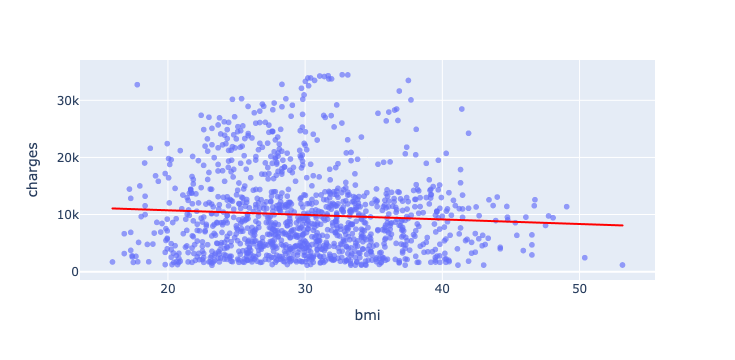

In [70]:
# Visualize bmi and charges
fig = px.scatter(
    healthins_df, x='bmi', y='charges', opacity=0.65,
    trendline='ols', trendline_color_override='red'
)
fig.show()

In [72]:
# Transform categorical to numerical
healthins_df['sex'] = healthins_df['sex'].map({'female':0, 'male':1})
healthins_df

/var/folders/bs/1wybxlr17fg3bj7w8dhxkg1r0000gn/T/ipykernel_4131/1217060894.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,no,northwest,10600.54830
1334,18,0,31.920,0,no,northeast,2205.98080
1335,18,0,36.850,0,no,southeast,1629.83350
1336,21,0,25.800,0,no,southwest,2007.94500


In [74]:
healthins_df['smoker'] = healthins_df['smoker'].map({'no':0, 'yes':1})
healthins_df

/var/folders/bs/1wybxlr17fg3bj7w8dhxkg1r0000gn/T/ipykernel_4131/1841293685.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,northwest,10600.54830
1334,18,0,31.920,0,0,northeast,2205.98080
1335,18,0,36.850,0,0,southeast,1629.83350
1336,21,0,25.800,0,0,southwest,2007.94500


In [76]:
healthins_df['region'] = healthins_df['region'].map({'southwest':0, 'southeast':1, 'northwest':2, 'northeast':3})
healthins_df

/var/folders/bs/1wybxlr17fg3bj7w8dhxkg1r0000gn/T/ipykernel_4131/3054436920.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,0,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,2,21984.47061
4,32,1,28.880,0,0,2,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2,10600.54830
1334,18,0,31.920,0,0,3,2205.98080
1335,18,0,36.850,0,0,1,1629.83350
1336,21,0,25.800,0,0,0,2007.94500


In [84]:
#Split dependent and independent variables 

X = healthins_df.drop(['charges'], axis=1)
y = healthins_df['charges']
X

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,0
1,18,1,33.770,1,0,1
2,28,1,33.000,3,0,1
3,33,1,22.705,0,0,2
4,32,1,28.880,0,0,2
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2
1334,18,0,31.920,0,0,3
1335,18,0,36.850,0,0,1
1336,21,0,25.800,0,0,0


In [86]:
# Scale the data with Standard Scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to test data
X_test_scaled = scaler.transform(X_test)

### MODELING AND EVALUATION

#### MODEL 1:  Linear Regression

In [90]:
#Instantiate and fit linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [92]:
print(linreg.coef_)
print(linreg.intercept_)

[  243.71056977  -472.11361123    76.0054115    358.07826909
 15067.34868907   480.37878006]
-4484.273820093869


In [98]:
y_train_pred_lr = linreg.predict(X_train)
y_test_pred_lr = linreg.predict(X_test)

# Define evaluation metrics 
eval_metrics = {
    'R2 Train': r2_score(y_train, y_train_pred_lr),
    'R2 Test': r2_score(y_test, y_test_pred_lr),
    'MSE Train': mean_squared_error(y_train, y_train_pred_lr),
    'MSE Test': mean_squared_error(y_test, y_test_pred_lr),
    'MAE Train': mean_absolute_error(y_train, y_train_pred_lr),
    'MAE Test': mean_absolute_error(y_test, y_test_pred_lr)
}

# Print metrics
m1_eval_metrics = []
for name, value in eval_metrics.items():
    print(f"{name}: {value:.8f}")
    m1_eval_metrics.append(value)

R2 Train: 0.61026164
R2 Test: 0.57455135
MSE Train: 20247529.19282764
MSE Test: 22885929.48195051
MAE Train: 2496.99437510
MAE Test: 2612.56654197


#### MODEL 2:  Lasso Regression

#### MODEL 3:  Ridge Regression